# *Gender Bias in Virtual Assistants Project*

### Identificando Preconceitos de Gênero em Assistentes Virtuais

![From Google](../resources/images/gender_bias.png)

### Equipe formada por
- Bárbara Stéphanie Neves Oliveira, 507526
- Lucas Benjamim Cunha Bandeira, 507533
- Samir Braga Chaves, 513788
- Vinicius Bernardo Gabriel, 475210


# *Wikipedia Toxic Comments Dataset* 

Uma das principais frentes do presente trabalho trata-se da identificação do nível de ofença ou toxicidade presente em textos de diálogos entre uma assistente virtual e um usuário. Por não existir hoje (pelo o que sabemos) um conjunto de diálogos anotados com tipos de ofensas e não apenas emoções (tal como no trabalho de [Dinan *et al*. (2019)](https://arxiv.org/pdf/1710.03957.pdf), escolhemos fazer uso do conjunto de dados *Wikipedia Toxic Comments* (WCT) para realização desta tarefa em específico.

![Kaggle - Toxic Comment Classification Challenge](../resources/images/toxic_comment_challenge.png)

O conjunto de dados WTC foi criado tanto pela [*Wikimedia Foundation*](https://wikimediafoundation.org/) quanto pela [*Jigsaw*](https://jigsaw.google.com/) (uma empresa do Google) para [identificar ataques pessoais *online*](https://jigsaw.google.com/the-current/toxicity/). Os dados foram extraídos das páginas de discussão da Wikipédia, onde os editores discutem melhorias em artigos ou em outras páginas. 

Consideramos a versão do conjunto de dados que corresponde à competição no [*Kaggle: Toxic Comment Classification Challenge*](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/). Como não há diálogos anotados com um nível de toxicidade disponíveis publicamente, usaremos os dados do WTC para realizar um *bootstrap* (abordagem inicial) do problema de identificação de toxicidade e ofensas em diálogos. 

---

### Descrição do WTC *Dataset*

O *dataset* possui um grande número de comentários do Wikipédia rotulados manualmente com 7 classes.

- **Sumário:**
> - 4 arquivos (estamos usando os arquivos `train.csv`, `test.csv` e `test_labels.csv`)
> - Possui 52.63 MB de tamanho



# Imports

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from collections import Counter 

# Pré-processamento de textos
import string
from spacy.lang.en import STOP_WORDS
from wordcloud import WordCloud

CMAP_ICEFIRE = plt.get_cmap('icefire')
DEFAULT_FONT_SIZE = 14
plt.rcParams['font.size'] = DEFAULT_FONT_SIZE

BASE_PATH = '..'
DATASETS_PATH = BASE_PATH + '/resources/datasets'

In [5]:
# Adicionando módulos customizados ao path
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append(BASE_PATH + '/modules')
import utils
from importlib import reload

reload(utils)

<module 'utils' from '/Users/samirchaves/Documents/atividades/ds/gender-bias-in-virtual-assistants/exploratory-data-analysis/../modules/utils.py'>

# Leitura dos Dados

In [6]:
train_df = pd.read_csv(DATASETS_PATH + '/Wikipedia Toxic Comments/train.csv')
test_df = pd.read_csv(DATASETS_PATH + '/Wikipedia Toxic Comments/test.csv')
test_labels_df = pd.read_csv(DATASETS_PATH + '/Wikipedia Toxic Comments/test_labels.csv')

len(train_df), (len(test_df), len(test_labels_df))

(159571, (153164, 153164))

## Verificando os dados de teste

In [7]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [8]:
test_labels_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [9]:
# Realizando o merge dos textos e das labels baseado em id's iguais
test_df = pd.merge(test_df, test_labels_df, on='id')

test_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [10]:
# Segundo a página do Kaggle, o valor -1 indica que a label não foi usada para pontuação
# Desta forma, iremos substituir os valores de -1 por 0
test_df.update(test_df.loc[:, list(test_df.columns[-6:])].replace({-1: 0}))

test_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0,0,0,0,0,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0,0,0,0,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0,0,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",0,0,0,0,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,0,0,0,0,0,0


## Concatenando os dados de treino e teste


In [11]:
df = train_df.append(test_df, ignore_index=True)

df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [12]:
print('Número de instâncias = {}'.format(len(df)))
print('Número de atributos = {}'.format(len(df.columns)))

Número de instâncias = 312735
Número de atributos = 8


In [13]:
print('Tipos de cada atributo:\n{}'.format(df.dtypes))

Tipos de cada atributo:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object


In [14]:
print('Valores faltantes em cada coluna:')
for col in df.columns:
  print('{} = {}'.format(col, df[col].isnull().sum()))

Valores faltantes em cada coluna:
id = 0
comment_text = 0
toxic = 0
severe_toxic = 0
obscene = 0
threat = 0
insult = 0
identity_hate = 0


In [15]:
dups = df.duplicated()
print('Número de linhas duplicadas = {}'.format(dups.sum()))

Número de linhas duplicadas = 0


# Análise Exploratória

O WTC *dataset* trata-se de um típico corpus anotado que pode ser utilizado em tarefas de NLP. As 2 primeiras colunas indicam a parte textual do *dataset*, em que a primeira (`id`) possui os identificadores dos comentários, e a segunda (`comment_text`), os textos.

Os restantes dos atributos tratam-se dos rótulos. Iremos analisá-los com mais detalhes ainda neste *notebook*, mas notamos antecipadamente que os dados são **multirótulo**, isto é, os textos estão anotados com mais de uma classe. Assim, considerando os 6 últimos atributos como um vetor de 6 posições, temos o seguinte cenário:

- `toxic` - primeiro rótulo. Se o comentário for tóxico, é colocado o valor 1 no índice 0.
- `severe_toxic` - segundo rótulo. Se o comentário for tóxico grave, é colocado o valor 1 no índice 1.
- `obscene` - terceiro rótulo. Se o comentário for obsceno, é colocado o valor 1 no índice 2.
- `threat` - quarto rótulo. Se o comentário for uma ameaça, é colocado o valor 1 no índice 3.
- `insult` - quinto rótulo. Se o comentário for um insulto, é colocado o valor 1 no índice 4.
- `identity_hate` - sexto rótulo. Se o comentário trata-ser de um ódio à indetidade, é colocado o valor 1 no índice 5.

Dado que temos um ***dataset* multirótulo**, um texto pode estar anotado, no máximo, com todos os rótulos listados acima. No entanto, para um texto que não possui nenhum tipo de toxicidade, o valor 0 é atribuído para todas as posições do vetor alvo. Por isso que, na verdade, são consideradas 7 classes no total. Para um texto que não possui toxicidade, chamaremos o "rótulo" não-tóxico de `safe`. 

Tudo o que foi explanado acima pode ser confirmado a seguir. Observe que os 6 primeiros comentários são não-tóxicos (`safe`), enquanto que o 7º comentário trata-se de um texto tóxico, tóxico grave, obsceno, além de também ser um insulto e de possuir alguns palavrões.

In [16]:
df[:7]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


## Estatísticas de Resumo

Primeiramente, iremos capturar algumas características dos dados ao observar suas estatísticas de resumo. Para visualizar melhor estas estatísticas, exibimos abaixo as informações em formato gráfico ou tabular.



In [17]:
# Describe das colunas categóricas
df.describe(include='O')

,id,comment_text
count,312735,312735
unique,312735,312735
top,37746e3d51356713,Stick with the ref-style footnotes that the ar...
freq,1,1


In [18]:
# Describe das colunas numéricas (rótulos)
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,312735.000000,312735.000000,312735.000000,312735.000000,312735.000000,312735.000000
mean,0.068377,0.006274,0.038819,0.002203,0.036146,0.006769
std,0.252393,0.078958,0.193163,0.046886,0.186653,0.081997
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- **Ocorrências dos rótulos:**

> Os valores e gráficos presentes abaixo possuem a quantidade de ocorrências por rótulo. É possível notar que, além da quantidade de comentários `safe` ser bem próxima do tamanho de todo o *dataset*, também estamos lidando com dados desbalanceados. Guardaremos esta informação para o futuro.
>
> Como temos cerca de 313 mil textos (uma quantidade muito grande de dados), na etapa de pré-processamento, não discutida neste *notebook*, iremos utilizar uma *sample* menor e balanceada destes dados (pelo menos no que diz respeito aos rótulos `safe` e `toxic`, que possuem a maior quantidade de ocorrências).

In [19]:
labels = list(test_df.columns[-6:]) + ['safe']
labels_count = df[labels[:-1]].sum().to_numpy() # Tirando safe da contagem

for l in labels[:-1]:
  print("Rótulo =", l)
  print(df[l].value_counts(), '\n')

Rótulo = toxic
0    291351
1     21384
Name: toxic, dtype: int64 

Rótulo = severe_toxic
0    310773
1      1962
Name: severe_toxic, dtype: int64 

Rótulo = obscene
0    300595
1     12140
Name: obscene, dtype: int64 

Rótulo = threat
0    312046
1       689
Name: threat, dtype: int64 

Rótulo = insult
0    301431
1     11304
Name: insult, dtype: int64 

Rótulo = identity_hate
0    310618
1      2117
Name: identity_hate, dtype: int64 



In [20]:
df['labels_count'] = df[labels[:-1]].sum(axis=1)
df['if_safe'] = df['labels_count'] == 0

safe_label_count = df['if_safe'].value_counts().to_numpy()[0]
labels_count = np.append(labels_count, safe_label_count)

# Verificando se os primeiros 6 valores estão de acordo com os mostrados acima
print('Quantidade de ocorrências de cada rótulo (incluindo safe) = {}'.format(labels_count)) 

Quantidade de ocorrências de cada rótulo (incluindo safe) = [ 21384   1962  12140    689  11304   2117 290267]


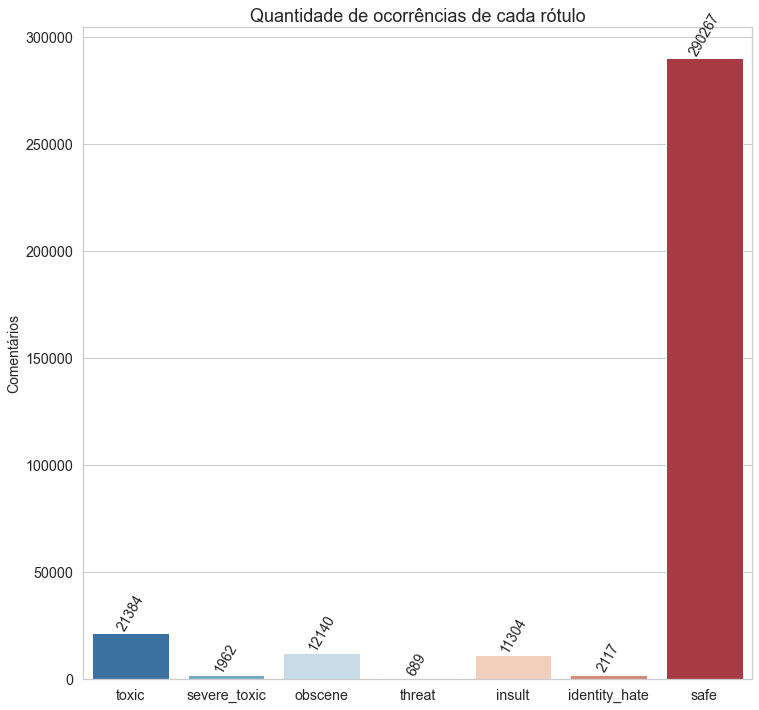

In [21]:
utils.plot_histogram_labels(x_label=labels, 
                            y_label=labels_count, 
                            labels=labels_count, 
                            palette='RdBu_r',
                            title='Quantidade de ocorrências de cada rótulo', 
                            ylabel_title='Comentários', 
                            width=12,
                            height=12)

- **Porcentagem dos comentários não-tóxicos:**

> Como é possível verificar nas estatísticas e no gráfico acima, nem todos os comentários possuem algum nível de toxicidade. Isso é algo bom, pois assim o nosso modelo saberá identificar ainda mais o que pode ser ou não tóxico. O único problema é que, conforme identificamos abaixo, cerca de 93% do *dataset* possui apenas comentários `safe`. Também guardaremos esta informação para o futuro.

In [22]:
print('Percentual de comentários não-tóxicos (safe) = {}%'.format(safe_label_count/len(df)*100))

Percentual de comentários não-tóxicos (safe) = 92.81564263673717%


- **Quantidade de rótulos por cometário:**

> Com o gráfico abaixo, mostramos que os dados realmente são multirótulo. Dos 22.468 textos tóxicos, 8.202 textos estão anotados com apenas um rótulo, enquanto que apenas 45 dos textos possuem todos os níveis de toxicidade.

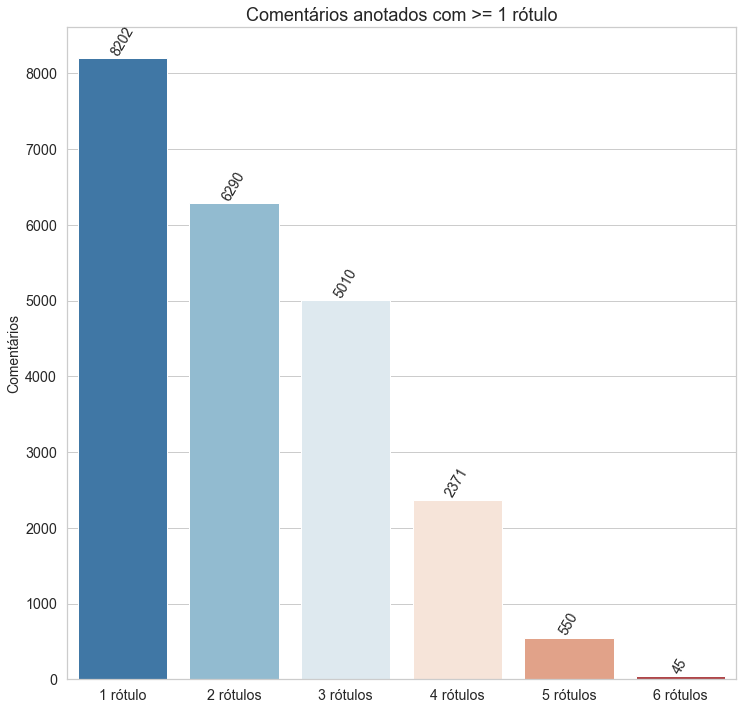

In [23]:
labels_count_per_comment = df['labels_count'].value_counts().iloc[1:]

indexes = [str(i) + ' rótulos' if i != 1 else str(i) + ' rótulo' 
           for i in labels_count_per_comment.index.sort_values()]

utils.plot_histogram_labels(x_label=indexes, 
                            y_label=labels_count_per_comment.to_numpy(), 
                            labels=labels_count_per_comment,
                            palette='RdBu_r',
                            title='Comentários anotados com >= 1 rótulo',
                            ylabel_title='Comentários', 
                            width=12,
                            height=12)

- **Matriz de correlação dos rótulos:**
> Avaliando a matriz de correlação abaixo, notamos que todos os rótulos tóxicos possuem uma correlação positiva, isto é, movem-se juntos. O que é esperado, já que faz sentido que os níveis de toxicidade possuam relações entre si. Das correlações próximas a 1, temos os rótulos `toxic`, `obscene` e `insult` movendo-se próximos, o que indica que são altas as changes de um texto tóxico também ser obsceno ou um insulto, por exemplo.


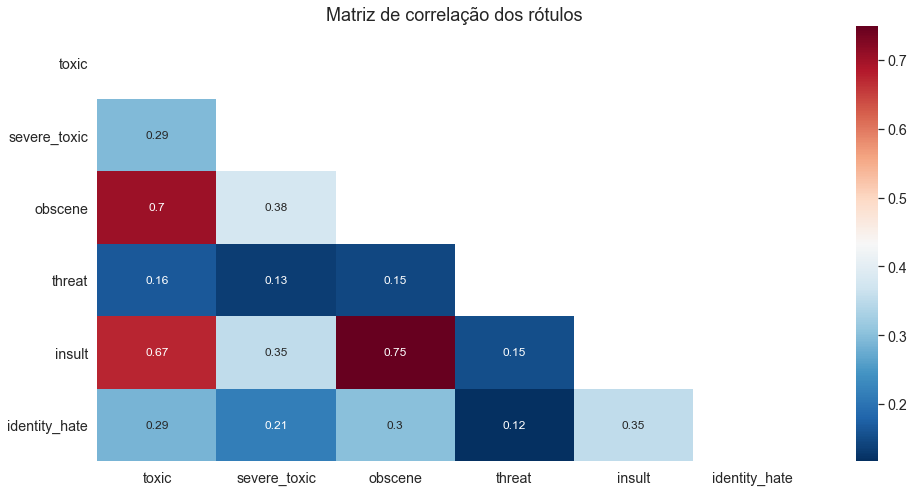

In [24]:
utils.plot_corr_matrix(df, labels[:-1], title='Matriz de correlação dos rótulos')

## Quais são as palavras mais comuns?

Para sabermos quais as palavras mais comuns presentes nos comentários, primeiramente iremos obter algumas estatísticas básicas oriundas do processo de tokenização. Depois, examinaremos quais são as palavras mais comuns através de nuvens de palavras.

In [25]:
# Tokenização simples e remoção de pontuações 
# Em lowercase para pegar as stopwords com diferentes formatos
df['comment_text_tokens'] = df['comment_text'].apply(lambda r: r.translate(str.maketrans('', '', string.punctuation)).lower().split()) 
df['comment_text_tokens_count'] = df['comment_text_tokens'].apply(lambda r: len(r)) # Quantidade de tokens de cada texto

df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels_count,if_safe,comment_text_tokens,comment_text_tokens_count
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,True,"[explanation, why, the, edits, made, under, my...",43
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,True,"[daww, he, matches, this, background, colour, ...",17
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,True,"[hey, man, im, really, not, trying, to, edit, ...",42
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,True,"[more, i, cant, make, any, real, suggestions, ...",109
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,True,"[you, sir, are, my, hero, any, chance, you, re...",13


In [26]:
# print('Estatísticas básicas dos tokens dos comentários=\n{}\n'.format(df['comment_text_tokens'].describe()))
print('Estatísticas básicas da contagem de tokens dos comentários =\n{}\n'.format(df['comment_text_tokens_count'].describe()))

# Todos os tokens dos comentários
all_comment_tokens = df['comment_text_tokens'].explode() 

print('Quantidade de palavras de todos os comentários = {}'.format(len(list(all_comment_tokens))))
print('Quantidade de palavras ÚNICAS de todos os comentários = {}'.format(len(set(all_comment_tokens))))
print('Quantidade das palavras ÚNICAS que SÃO stopwords = {}'.format(len([token for token in set(all_comment_tokens) if token in STOP_WORDS])))

Estatísticas básicas da contagem de tokens dos comentários =
count    312735.000000
mean         63.103618
std          98.007017
min           0.000000
25%          14.000000
50%          32.000000
75%          70.000000
max        2142.000000
Name: comment_text_tokens_count, dtype: float64

Quantidade de palavras de todos os comentários = 19734747
Quantidade de palavras ÚNICAS de todos os comentários = 475291
Quantidade das palavras ÚNICAS que SÃO stopwords = 307


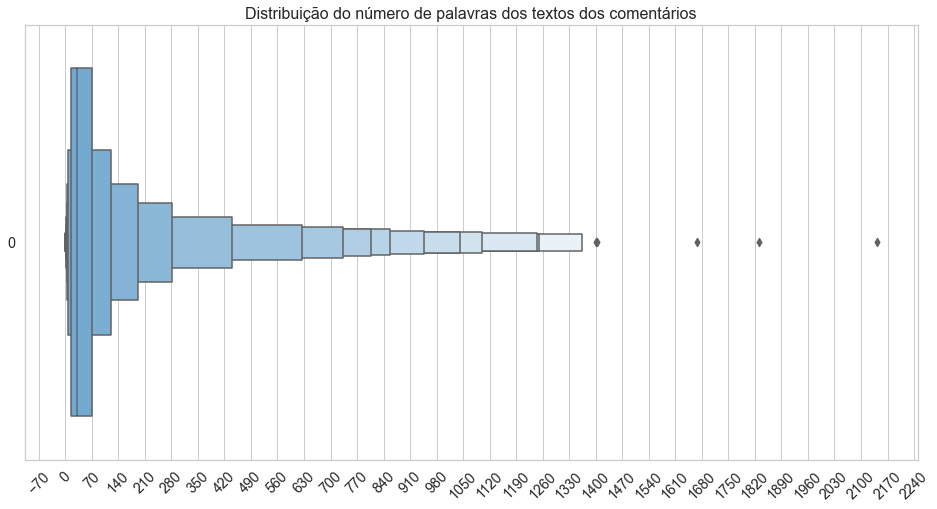

In [27]:
comment_tokens_percentil_75 = df['comment_text_tokens_count'].describe()['75%']

utils.plot_distribution_large_data(df['comment_text_tokens_count'], 
                                   title='Distribuição do número de palavras dos textos dos comentários', 
                                   xaxis_interval=comment_tokens_percentil_75)

Observe que o `.describe()` nos diz que o menor texto possui nenhuma palavra. Isso é um pouco estranho, mas faz completo sentido já que realizamos o processo de limpeza dos dados (remoção das *stopwords* e caracteres especiais, etc.). Listamos abaixo alguns dos textos com 0 *tokens* que, na verdade, são "lixo". Também guardaremos esta informação para o futuro, pois não faz sentido trabalhar com dados cheios de "lixo".

In [28]:
df.loc[df['comment_text_tokens_count'] == 0][0:10]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels_count,if_safe,comment_text_tokens,comment_text_tokens_count
164427,08323f2f0a13c416,""" \n\n \n * """,0,0,0,0,0,0,0,True,[],0
166104,0af7effe1fd4b873,',0,0,0,0,0,0,0,True,[],0
168226,0e81ddea7fec8962,=== ===,0,0,0,0,0,0,0,True,[],0
175243,1a56b331b2acc0da,""" \n\n '''' / """,0,0,0,0,0,0,0,True,[],0
175631,1af5554667a8c913,* \n * \n * \n * \n * \n * \n * \n * ...,0,0,0,0,0,0,0,True,[],0
187638,2ebb8aefc22c92f9,""" \n\n :~ """,0,0,0,0,0,0,0,True,[],0
191536,35255b6638eec7b0,""" \n * \n\n """,0,0,0,0,0,0,0,True,[],0
193744,38dbade4aa845e09,- -,0,0,0,0,0,0,0,True,[],0
193875,390e5fde2cc12223,| \n\n \n |,0,0,0,0,0,0,0,True,[],0
194386,39ebd3b58c17cbb0,* * *,0,0,0,0,0,0,0,True,[],0


In [29]:
all_comment_clean_tokens = [token for token in all_comment_tokens if token not in STOP_WORDS]

# Palavras mais comuns
most_common_tokens = utils.make_most_common_words(all_comment_tokens, n_most_common=50)
# Palavras mais comuns e sem stopwords
most_common_clean_tokens = utils.make_most_common_words(all_comment_clean_tokens, n_most_common=50)

wc_common_tokens = utils.generate_wordcloud(dict(most_common_tokens))
wc_common_clean_tokens = utils.generate_wordcloud(dict(most_common_clean_tokens))

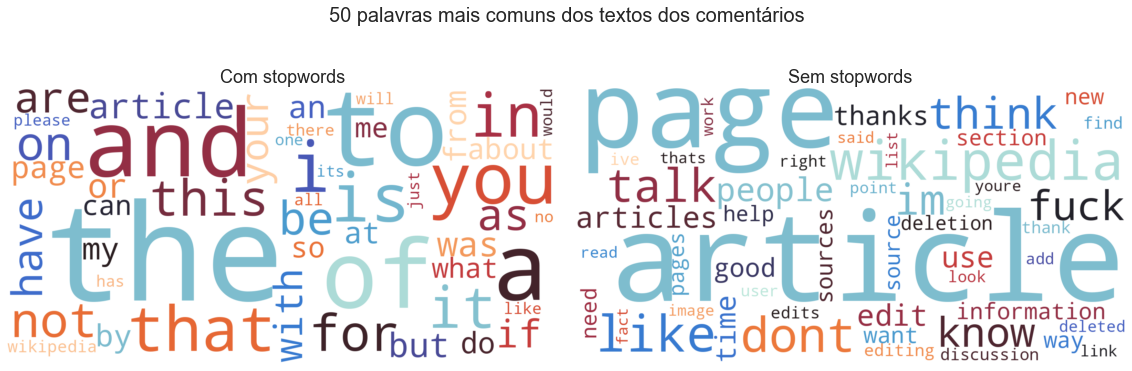

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
fig.suptitle('50 palavras mais comuns dos textos dos comentários', y=0.85, fontsize=20)

ax[0].imshow(wc_common_tokens, interpolation='bilinear')
ax[1].imshow(wc_common_clean_tokens, interpolation='bilinear')

ax[0].axis('off')
ax[0].set_title('Com stopwords', fontdict={'fontsize': 18})

ax[1].axis('off')
ax[1].set_title('Sem stopwords', fontdict={'fontsize': 18})
fig.tight_layout()

Como era de se esperar de um dado textual, a nuvem de palavras da direita nos mostra que os termos mais frequentes no *dataset* são *stopwords*, o que confirma mais uma vez a importância do processo de remoção destes termos. No entanto, a nuvem de palavras da direita ainda nos mostra alguns termos que, apesar de não serem *stopwords*, podem não estar relacionados com os rótulos, o que é justamente o nosso próximo passo. A seguir, analisaremos e removeremos alguns destes termos.

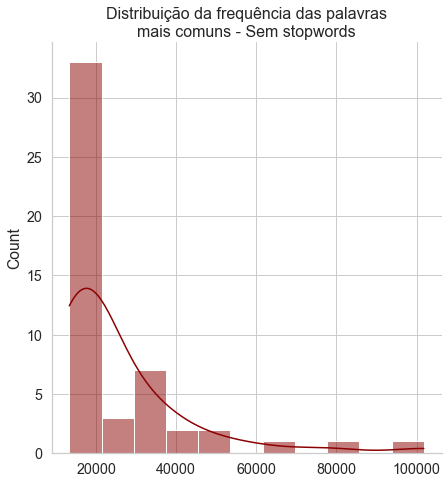

In [31]:
sns.set(style='whitegrid', font_scale=1.3)
sns.displot(ax=ax[0], data=[tup[1] for tup in most_common_clean_tokens], kde=True, color='darkred', height=6.5)
plt.title('Distribuição da frequência das palavras\nmais comuns - Sem stopwords', fontsize=16)
plt.show()

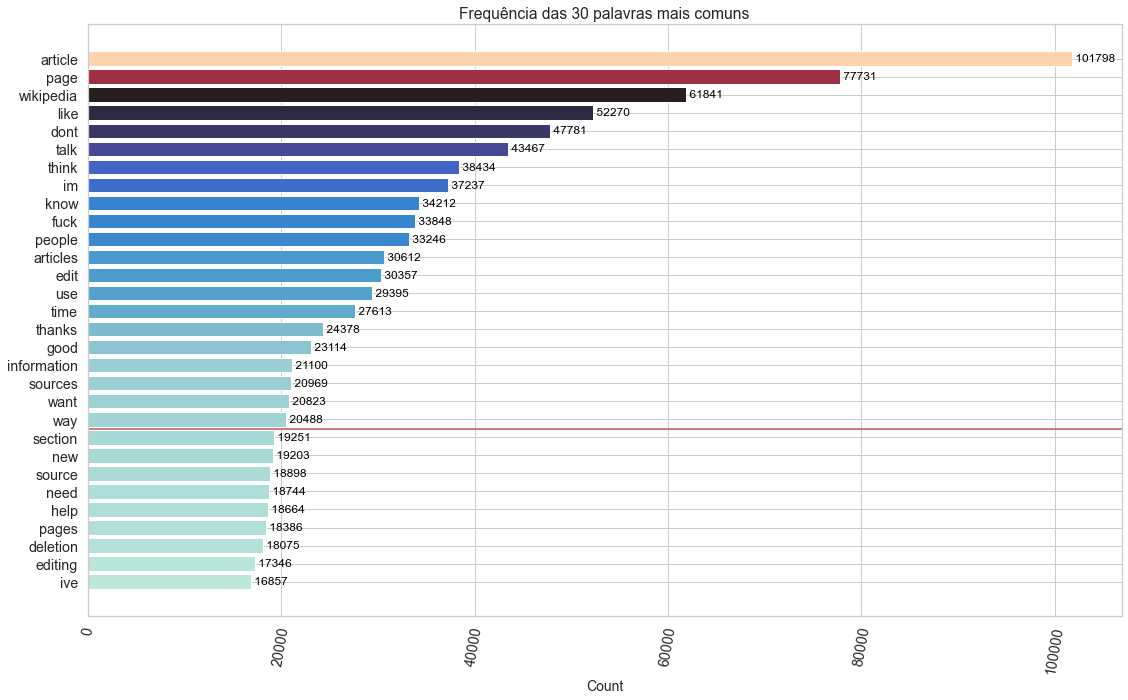

In [32]:
plt.figure(figsize=(16, 10))
utils.plot_most_frequent_elements(Counter(dict(most_common_clean_tokens)), 
                                  n_most_common=30, 
                                  title='Frequência das 30 palavras mais comuns')
plt.axhline(y=8.46, color='r', linestyle='-');

In [33]:
# As palavras ignoradas são as que aparecem mais de 20.000 vezes
words2ignore = [tup[0] for tup in most_common_clean_tokens if tup[1] > 20000]
set_stop_words2ignore = STOP_WORDS.union(set(words2ignore))

print('Quantidade de palavras que devem ser ignoradas = {}'.format(len(words2ignore)))
print('Quantidade de palavras que devem ser ignoradas juntamente com as stopwords = {}'.format(len(set_stop_words2ignore)))

Quantidade de palavras que devem ser ignoradas = 21
Quantidade de palavras que devem ser ignoradas juntamente com as stopwords = 347


## Quais são as palavras mais comuns por rótulo?

### Rótulo não-tóxico

Mostramos abaixo a nuvem de palavras correspondente aos comentários anotados como `safe`. Observe que, mesmo que tenhamos retirado as palavras que aparecem mais de 20.000 vezes, algumas das palavras destacadas na nuvem estão presentes no gráfico da *Frequência das 50 palavras mais comuns* (apresentado anteriormente). Além delas, também estão presentes algumas palavras neutras, que não nos dizem muito sobre os tipos de assuntos existentes nesses comentários não-tóxicos, embora fique claro que os dados tratam-se mesmo de discussões em artigos e em outras páginas do Wikipédia, por conta da presença de palavras como *deletion*, *edits*, *read*, *discussion*, *editing*, *pages* e *thank*.

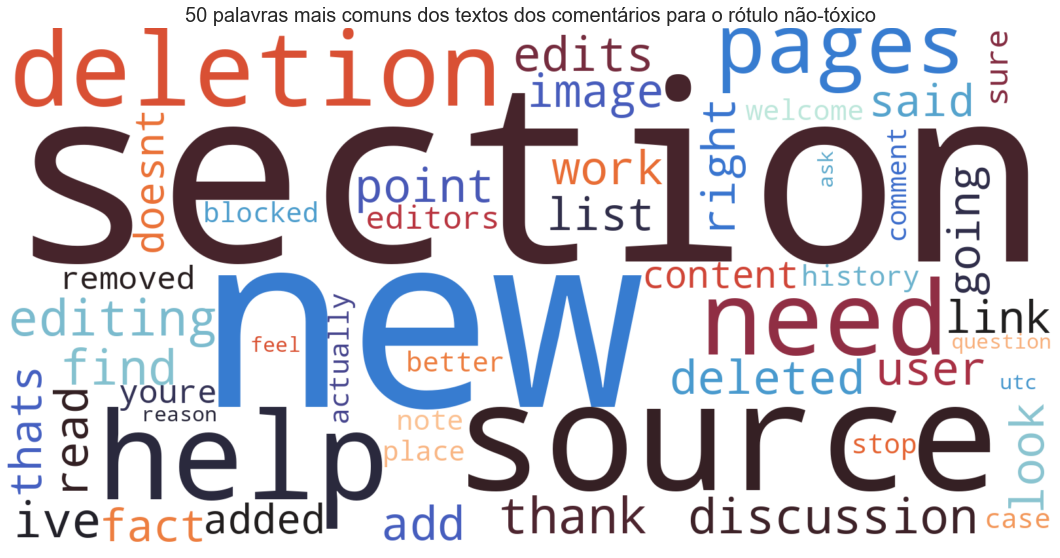

In [34]:
df_comment_safe_label = df['comment_text_tokens'].loc[df['if_safe']]
all_safe_label_comment_tokens = [word for word in df_comment_safe_label.explode().tolist() if word not in set_stop_words2ignore]

safe_label_most_common_tokens = utils.make_most_common_words(all_safe_label_comment_tokens, n_most_common=50)
wc_safe_label_most_common_tokens = utils.generate_wordcloud(dict(safe_label_most_common_tokens))

# Plot da word cloud
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('50 palavras mais comuns dos textos dos comentários para o rótulo não-tóxico', fontsize=20)
plt.imshow(wc_safe_label_most_common_tokens, interpolation='bilinear')
plt.tight_layout()

### Rótulos tóxicos

Para os rótulos tóxicos, o que notamos primordialmente é a presença de termos ofensivos e palavrões nas nuvens de palavras. Praticamente, todas as nuvens de palavras estão indecifráveis por possuírem palavras bem "tóxicas". 

- ***Warning*:** 
> Fique ciente que as próximas nuvens de palavras possuem muitos termos ofensivos, palavrões e palavras de baixo calão!

In [35]:
# Para salvar as word clouds por rótulo tóxico
word_clouds = []

for label in labels[:-1]:
  df_comment_label = df['comment_text_tokens'].loc[df[label] == 1]
  all_label_comment_tokens = [word for word in df_comment_label.explode().tolist() if word not in set_stop_words2ignore]
  
  label_most_common_tokens = utils.make_most_common_words(all_label_comment_tokens, n_most_common=50)
  wc = utils.generate_wordcloud(dict(label_most_common_tokens))
  word_clouds.append((wc, '{} - {} comentários'.format(label, len(df_comment_label))))
  all_label_comment_tokens = [] 

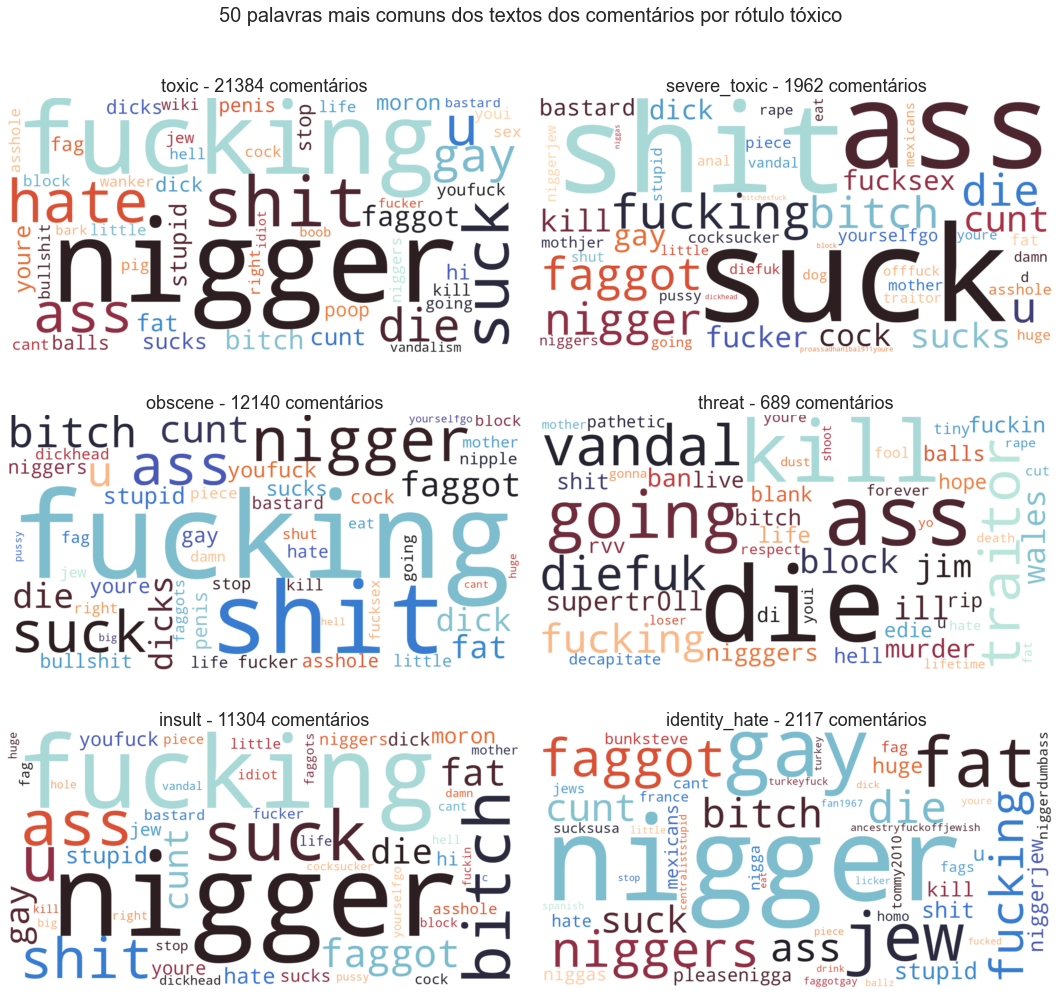

In [36]:
utils.subplot_topic_wordcloud(word_clouds, 
                              nrows=3, 
                              ncols=2, 
                              width=15, 
                              height=15, 
                              title='50 palavras mais comuns dos textos dos comentários por rótulo tóxico', 
                              range_stop=len(labels[:-1]), 
                              range_step=2)

## Qual a quantidade de palavras ofensivas nos comentários por rótulo?

Como visto anteriormente, as nuvens de palavras por rótulo tóxico possuem muitos termos ofensivos e palavras de baixo calão. No entanto, para entender melhor a distribuição destas palavras, precisamos identificar a quantidade destes termos, até mesmo para os comentários `safe`. Será que eles possuem muitos termos ofensivos, palavrões e palavras de baixo calão? 

Para realizar essa verificação, usamos o *List of Dirty, Naughty, Obscene, and Otherwise Bad Words* [[3](https://github.com/LDNOOBW/List-of-Dirty-Naughty-Obscene-and-Otherwise-Bad-Words)], repositório que contém uma lista de obscenidades e palavras de baixo calão em diferentes idiomas. Assim, usando uma das listas que está disponível em Inglês, podemos contar tais "obscenidades".

In [37]:
bad_words_per_label = []

with tqdm(total=len(labels), desc='Verficando a presença de bad words nos') as pbar:
  for label in labels:
    if label != 'safe':
      matched_sent = set(df['comment_text_tokens'].loc[df[label] == 1].explode()) & set(utils.bad_words)
      bad_words_per_label.append((label, len(matched_sent)))
    else:
      matched_sent = set(df['comment_text_tokens'].loc[df['if_safe']].explode()) & set(utils.bad_words)
      bad_words_per_label.append((label, len(matched_sent)))
    pbar.update(1)

bad_words_per_label

Verficando a presença de bad words nos: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


[('toxic', 156),
 ('severe_toxic', 109),
 ('obscene', 145),
 ('threat', 59),
 ('insult', 138),
 ('identity_hate', 99),
 ('safe', 211)]

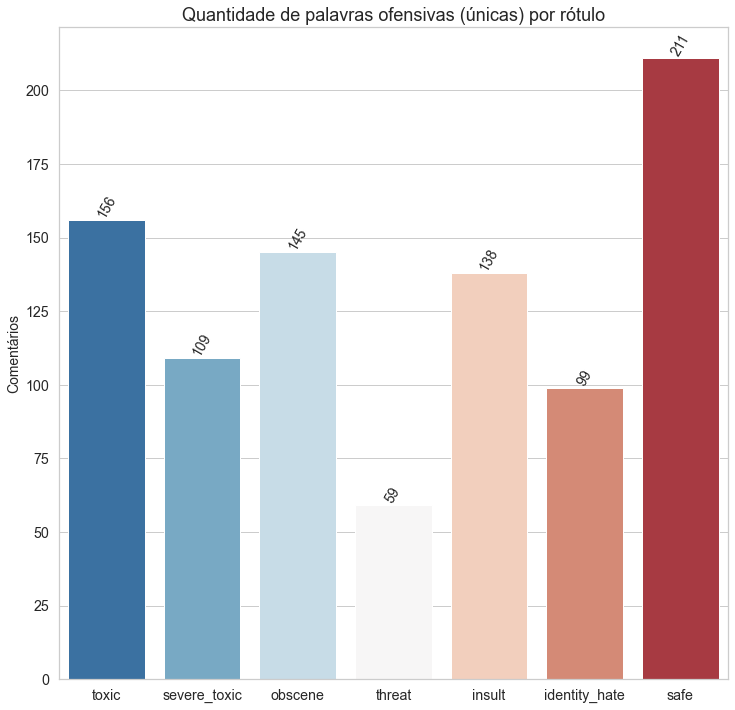

In [38]:
utils.plot_histogram_labels(x_label=labels, 
                            y_label=[i[1] for i in bad_words_per_label], 
                            labels=[i[1] for i in bad_words_per_label], 
                            palette='RdBu_r',
                            title='Quantidade de palavras ofensivas (únicas) por rótulo', 
                            ylabel_title='Comentários', 
                            width=12,
                            height=12)

Nota-se que a distribuição das palavras únicas ofensivas por rótulo (tóxico e não tóxico) segue a própria distribuição dos dados. No entanto, após uma rápida análise, é possível perceber que as sentenças em que essas palavras estão presentes podem não denotar sempre um caráter ofensivo quando contextualizadas. Seguem alguns exemplos:

In [39]:
# A palavra "sex" é considerada como bad word
utils.bad_words[306]

'sex'

In [40]:
df['comment_text'].loc[df['comment_text_tokens'].astype(str).str.contains(utils.bad_words[306])][2:4].to_numpy()

array(['A Bisexual, like a homosexual or a heterosexual, is not defined by sexual activity. (Much like a 15 year old boy who is attracted to a girl sexually but has never had sex is still straight). A person who is actually sexually attracted/aroused by the same sex as well as the opposite sex is bisexual.',
       '"know the sex of the foetus"""'], dtype=object)

# Referências

[[1](https://arxiv.org/pdf/1710.03957.pdf)] Li, Y., Su, H., Shen, X., Li, W., Cao, Z. and Niu, S., 2017. Dailydialog: A manually labelled multi-turn dialogue dataset. *arXiv preprint arXiv:1710.03957*.

[[2](https://insightlab.ufc.br/aprenda-a-estratificar-dados-multi-label-com-scikit-multilearn/)] Aprenda a estratificar dados multi-label com Scikit-multilearn. 2020. *Insight Data Science Lab*. Bárbara Neves.

[[3](https://github.com/LDNOOBW/List-of-Dirty-Naughty-Obscene-and-Otherwise-Bad-Words)] Our List of Dirty, Naughty, Obscene, and Otherwise Bad Words. 2020. *GitHub*. LDNOOBW.